# Praxisteil II: Bayessche Hierarchische Modelle (Lösung)

__Bayesian Workflow__

1. Problemstellung
2. Exploration der Daten
3. Bauen des Modells
4. Posterior Inference (Model Fitting)
5. Posterior Predictive Check
6. Parameter Inferenz
7. Modellvergleich (LM vs. BHM)
8. Modell verbessern

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

import pymc3 as pm
import arviz as az
import numpy as np

import math
import warnings
warnings.filterwarnings('ignore')

kwargs_sampler = {'chains': 4,'cores': 4}#, 'return_inferencedata': True}

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# Plotting
def plot_by_group(y,x,num_groups,group_idx,trace=None,fit=False):
    
    # Get number of rows and columns to plot
    if num_groups<=3:
        num_cols = num_groups
    else:
        num_cols = 3
    num_rows = math.ceil(num_groups/3)

    # Set up plot
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(20,10), sharex=True, sharey=True)
    ax = np.ravel(ax)

    # Plot each group
    x_range = np.linspace(x.min(), x.max(), 10)
    j = 0
    k = len(group_idx[group_idx==j])
    for i in range(num_groups):
        ax[i].scatter(x[j:k], y[j:k])
        ax[i].set_title(f"Group {i+1}", fontsize=15)
        
        if trace is not None:
            alpha_m = trace['beta_0'][:,i].mean()
            beta_m = trace['beta_1'][:, i].mean()
            
            ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
                       label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
        if fit:
            coef = np.polyfit(x[j:k], y[j:k],1)
            alpha_m = coef[1]
            beta_m = coef[0]
        
            ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
                       label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
            
        
        j += (group_idx==i).sum()
        k += (group_idx==i).sum()

    # Set common x and y axis
    fig.text(0.5, 0.07, 'Price', ha='center', fontsize=20)
    fig.text(0.09, 0.5, 'Sales', va='center', rotation='vertical', fontsize=20)

## Problemstellung

Nachdem du das erste Modell gebaut hast, schaust du dir die Struktur der Daten genauer an und bemerkst die Stores, die hierarchisch aufeinander aufgebaut sind (siehe Bild unten). Diese Struktur willst du in dein Modell einbauen, um den Datengenerierenden Prozess richtig abbilden zu können.

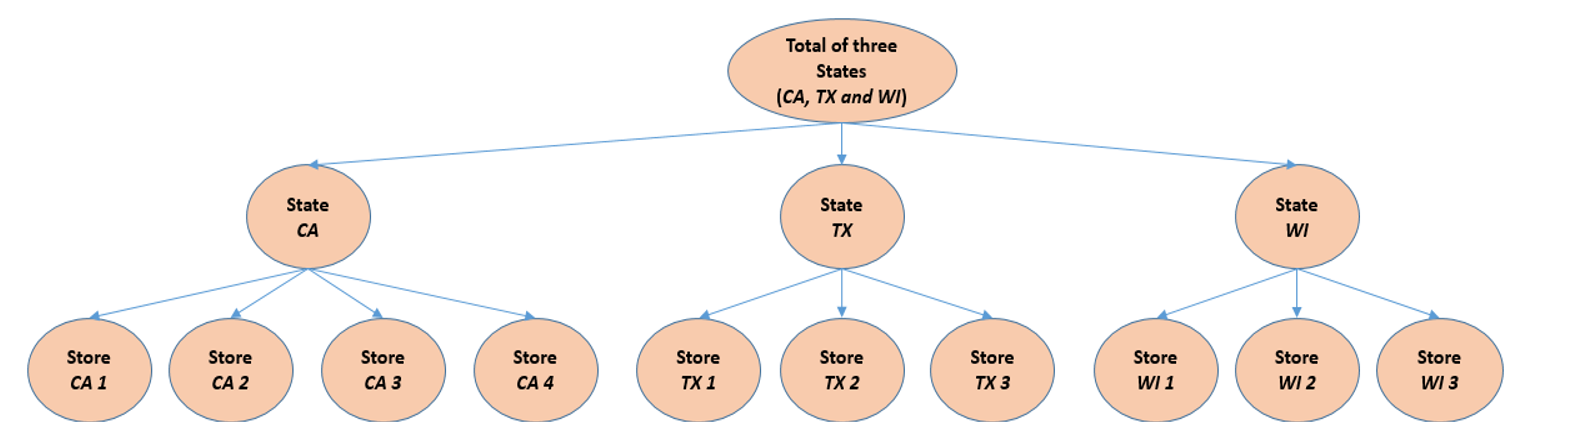

In [6]:
Image(filename = "imgs/hierarchical_structure.png", width = 1000, height = 1000)

## Exploration der Daten

In [8]:
# Load data
df = pd.read_csv('../data/dataset_sim.csv')
df.head()

,Sales,Price,Store
0,48.484536,5.749164,0
1,43.640838,4.796067,0
2,48.609230,4.817825,0
3,45.924189,5.680656,0
4,57.832635,3.181501,0


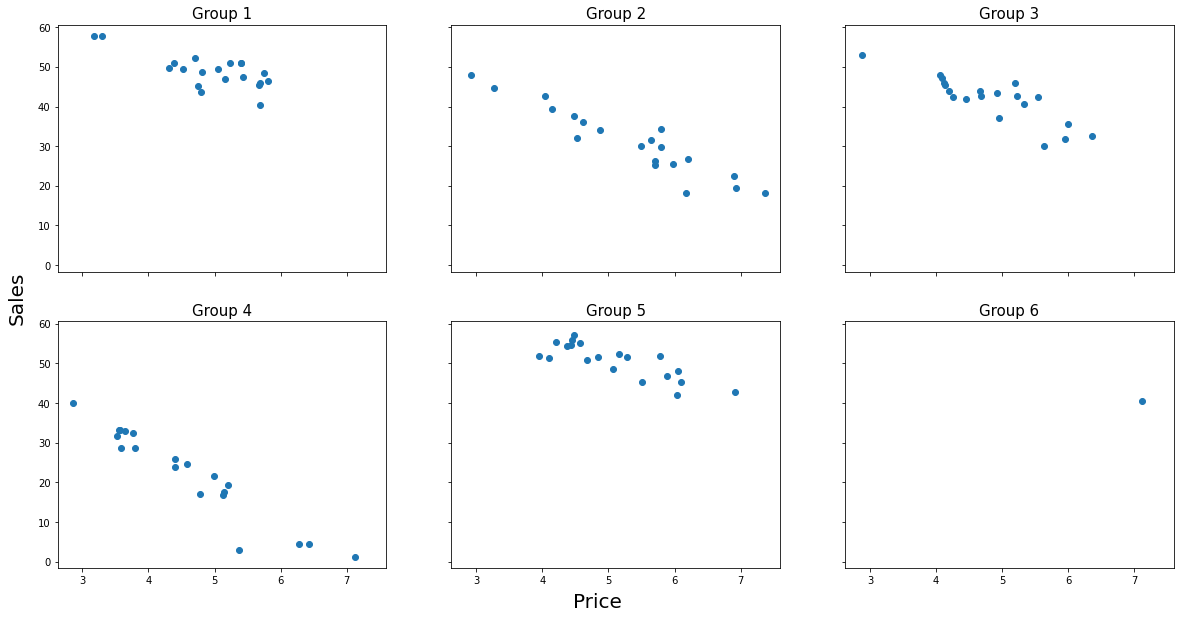

In [9]:
# Plot sales by groups
num_groups = df.Store.nunique()
group_idx = df.Store.to_numpy()

plot_by_group(df['Sales'],df['Price'],num_groups,group_idx)

## Bauen des Modells

### Pymc3 Implementierung

Die Implementierung findet Schrittweise statt, um den Prozess zu verdeutlichen:
- Schritt 1: Einzelne Modelle (Gruppen)
- Schritt 2: Hierarchie über Hyperprior hinzufügen

In [11]:
# Centering for better convergence
df['Price_centered'] = df['Price'] - df['Price'].mean()

# Group variables
group_idx = df['Store']
num_groups = df['Store'].nunique()

with pm.Model() as hierarchical_linear_model:
    
    # Priors for beta_0 prior (Hyperprior)
    #beta_0_mu = pm.Normal('beta_0_mu', mu=0, sd = 100)
    #beta_0_sigma = pm.HalfNormal('beta_0_sigma', sd = 100)
    
    # Priors for beta_1 prior (Hyperprior)
    #beta_1_mu = pm.Normal('beta_1_mu', mu=0, sd = 100)
    #beta_1_sigma = pm.HalfNormal('beta_1_sigma', sd = 100)
    
    # Hyperparameters
    #beta_0_scaled = pm.Normal('beta_0_scaled', mu=beta_0_mu, sd=beta_0_sigma, shape=num_groups)
    #beta_1 = pm.Normal('beta_1', mu=beta_1_mu, sd=beta_1_sigma, shape=num_groups)
    beta_0_scaled = pm.Normal('beta_0_scaled', mu=0, sd=100, shape=num_groups)
    beta_1 = pm.Normal('beta_1', mu=0, sd=100, shape=num_groups)
    eps = pm.HalfNormal('eps', 5)
    
    # Calculate mean of normal distribution (conditioning)
    mu = beta_0_scaled[group_idx] + beta_1[group_idx]*df['Price_centered']
    
    # Conditional normal distribution
    sales_pred = pm.Normal('sales_pred',mu=mu,sd=eps,observed=df['Sales'])
    
    beta_0 = pm.Deterministic('beta_0', beta_0_scaled - beta_1 * df['Price'].mean())

## Posterior Inference (Model Fitting)

### Sampling from the Posterior

In [13]:
with hierarchical_linear_model:
    # Trace
    trace_hierarchical_linear_model = pm.sample(**kwargs_sampler)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_1, beta_0_scaled]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


### Convergence Check

array([[<AxesSubplot:title={'center':'beta_0_scaled\n0'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n0'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n1'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n1'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n2'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n2'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n3'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n3'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n4'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n4'}>],
       [<AxesSubplot:title={'center':'beta_0_scaled\n5'}>,
        <AxesSubplot:title={'center':'beta_0_scaled\n5'}>],
       [<AxesSubplot:title={'center':'beta_1\n0'}>,
        <AxesSubplot:title={'center':'beta_1\n0'}>],
       [<AxesSubplot:title={'center':'beta_1\n1'}>,
        <AxesSubplot:title={'center':'beta_1\n1'}>],
       [<AxesSubplot:title={'center':'beta_1\n2'}>,
        <AxesSubplot:tit

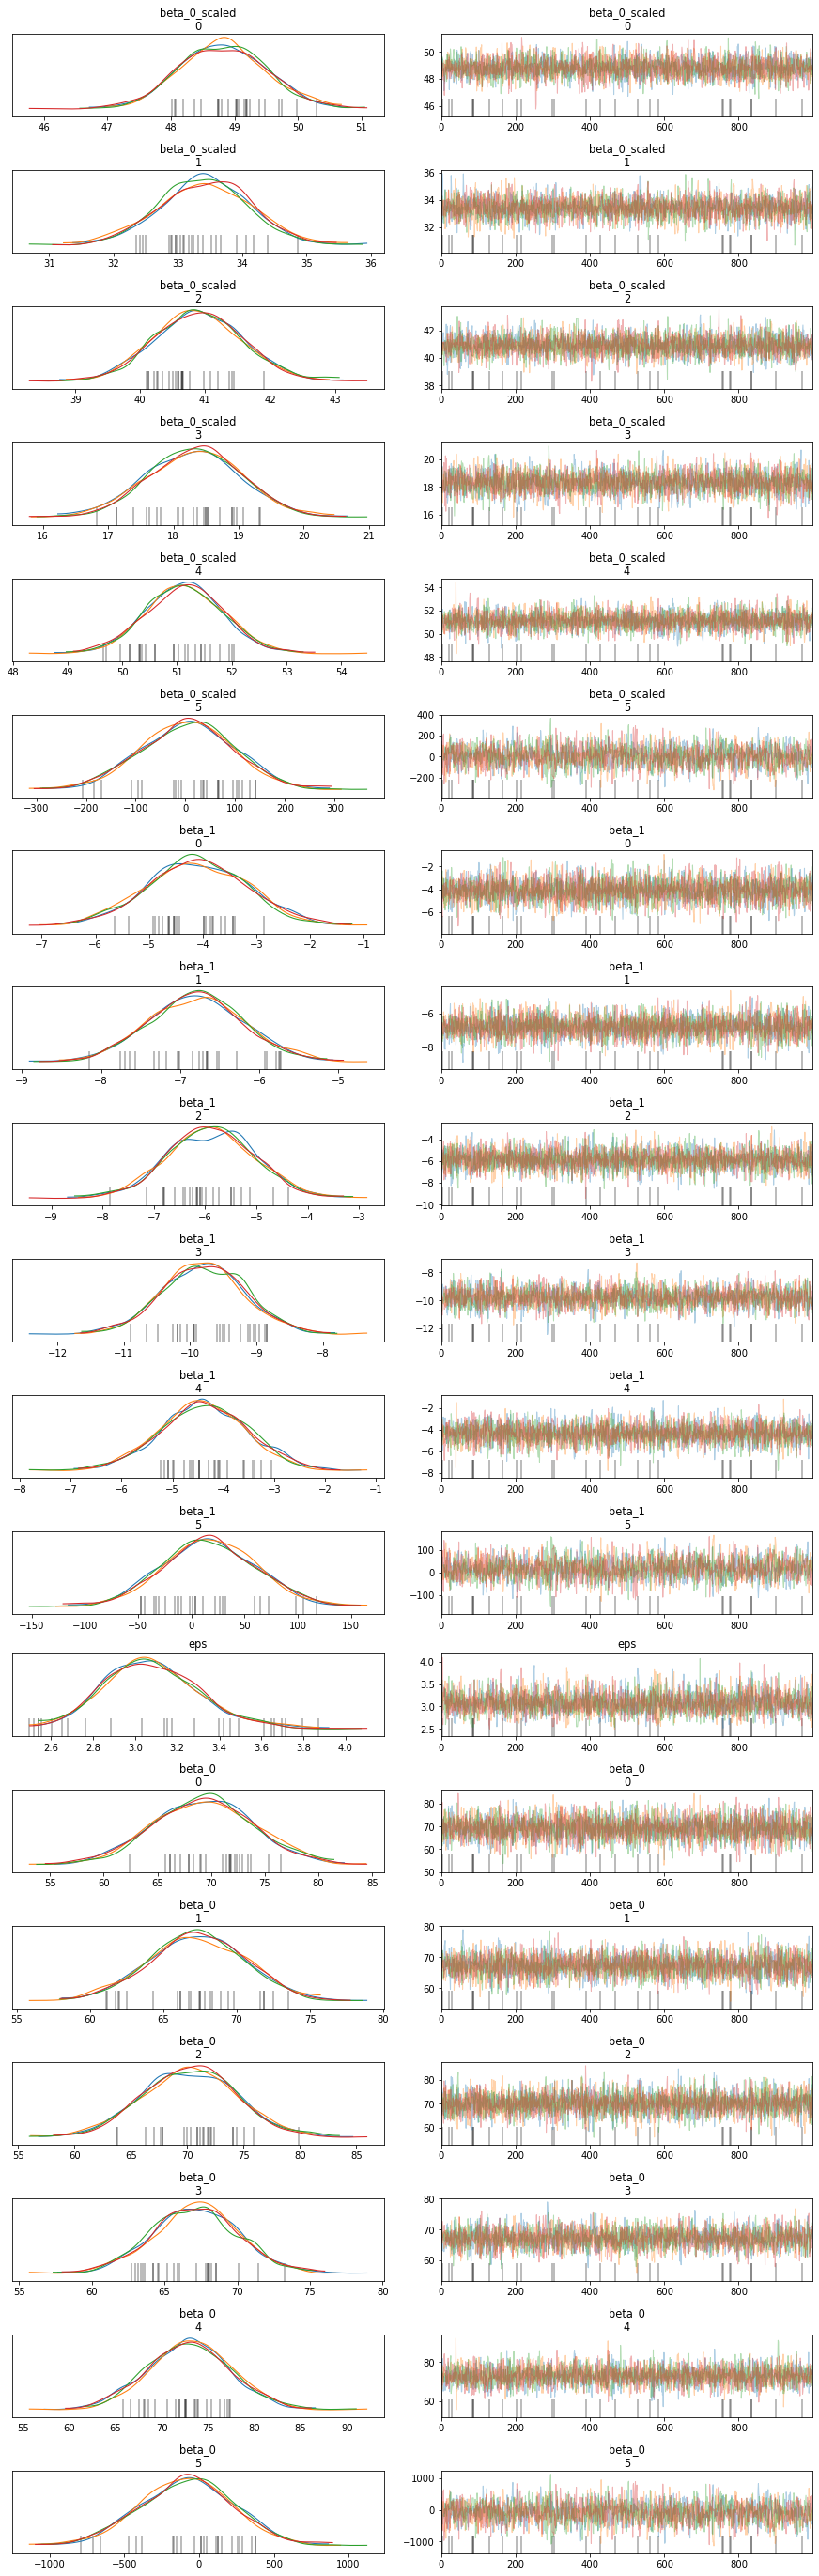

In [14]:
# Analyze the results
az.plot_trace(trace_hierarchical_linear_model)

In [16]:
# Tabular summary
az.summary(trace_hierarchical_linear_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_0_scaled[0],48.820,0.685,47.591,50.144,0.010,0.007,4256.0,4251.0,4275.0,3137.0,1.0
beta_0_scaled[1],33.418,0.710,32.094,34.753,0.011,0.008,3933.0,3933.0,3934.0,2858.0,1.0
beta_0_scaled[2],40.902,0.681,39.614,42.160,0.010,0.007,4666.0,4645.0,4629.0,2752.0,1.0
beta_0_scaled[3],18.328,0.726,16.980,19.689,0.012,0.009,3487.0,3487.0,3497.0,2382.0,1.0
beta_0_scaled[4],51.137,0.706,49.849,52.481,0.011,0.007,4449.0,4447.0,4436.0,2463.0,1.0
beta_0_scaled[5],3.449,94.193,-178.583,172.261,1.976,1.761,2272.0,1432.0,2282.0,2146.0,1.0
beta_1[0],-4.102,0.935,-5.861,-2.333,0.014,0.010,4301.0,4116.0,4303.0,2520.0,1.0
beta_1[1],-6.798,0.601,-7.963,-5.705,0.009,0.006,4384.0,4377.0,4374.0,3024.0,1.0
beta_1[2],-5.881,0.854,-7.514,-4.322,0.012,0.009,4709.0,4617.0,4716.0,3146.0,1.0
beta_1[3],-9.795,0.632,-10.897,-8.517,0.012,0.009,2756.0,2756.0,2776.0,2387.0,1.0


## Posterior Predictive Check

In [17]:
# Predict observations from the model by posterior predictive sampling
with hierarchical_linear_model:
    ppc_lhm = pm.sample_posterior_predictive(
        trace_hierarchical_linear_model, var_names=['beta_0','beta_1','sales_pred'], random_seed=58
    )

<AxesSubplot:xlabel='sales_pred'>

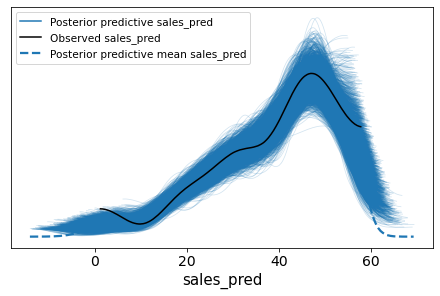

In [19]:
# We can use the plot the conditional distribution of y
idata = az.from_pymc3(trace_hierarchical_linear_model, posterior_predictive=ppc_lhm)
az.plot_ppc(idata)

## Parameter inference

### Posterior Distributions

In [ ]:
# Plot posterior distributions
az.plot_posterior(trace_hierarchical_linear_model) 

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

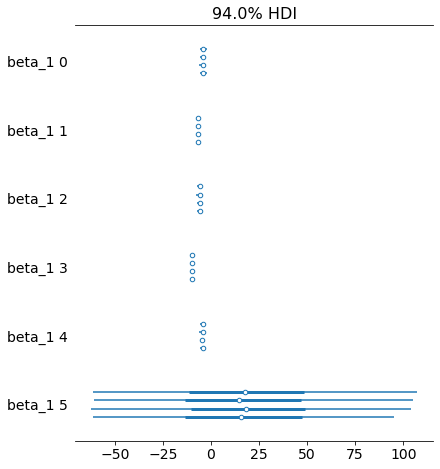

In [20]:
# Analyze the results
az.plot_forest(trace_hierarchical_linear_model, var_names='beta_1')

### Fitted models

In [ ]:
# Plot by group
plot_by_group(df['Sales'],df['Price'],num_groups,group_idx,trace_hierarchical_linear_model)

## Modellvergleich

In [33]:
# Build linear model again
with pm.Model() as linear_model:
    
    # Hyperparameters
    beta_0 = pm.Normal('beta_0', mu=0, sd=100)
    beta_1 = pm.Normal('beta_1', mu=-20, sd=50)
    eps = pm.HalfNormal('eps', 5)
    
    # Calculate mean of normal distribution (conditioning)
    #mu = pm.Deterministic('mu', beta_0 + beta_1*df['Price'])
    mu = beta_0 + beta_1*df['Price']
    
    # Conditional normal distribution
    sales_pred = pm.Normal('sales_pred',mu=mu,sd=eps,observed=df['Sales'])
    
    # Sample
    trace_linear_model = pm.sample(**kwargs_sampler)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta_1, beta_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [34]:
cmp_df = az.compare({'Linear model': trace_linear_model,
                    'Hierarchical linear model': trace_hierarchical_linear_model},ic='waic')
cmp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Hierarchical linear model,0,-262.095,10.3297,0,1,6.48056,0,True,log
Linear model,1,-397.064,2.88097,134.969,3.05141e-46,10.069,9.71731,False,log


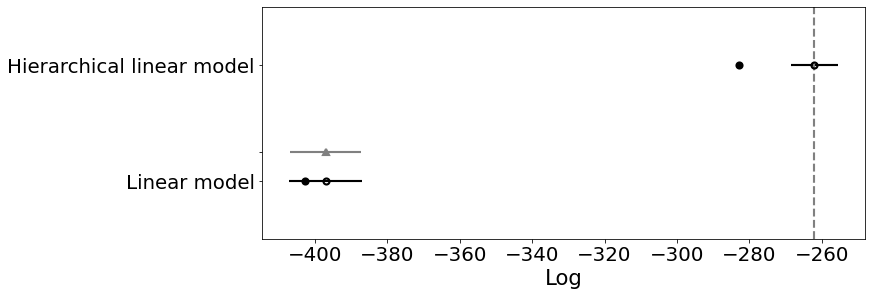

In [35]:
ax = az.plot_compare(cmp_df, figsize=(12, 4))

## Conclusion